In [1]:
"""
VES inversion for a blocky model
================================

Use variable distances for L and l in Schlumbeger geometry
"""
###############################################################################
# We import numpy, matplotlib and the 1D plotting function
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.viewer.mpl import drawModel1D

In [2]:
# A        M   N         B
# |        |   |         |
# V        V   V         V
# ab2 is AB/2 distance (current electrodes)
# mn2 is MN/2 distance (potential electrodes)
#

In [3]:
# survey 1
###############################################################################
# some hypothesis on nr. of layers, and average error
nlay = 10  # number of layers
errPerc = 5  # relative error of 3 percent
###############################################################################
# electrode distances and resistance measurements
ab2 = [.75,  1.0,   1.5,   2.0,    3.0,   5.0,   8.0,   10,   20,   30,    60,     90,  120]
mn2 = [.5,    .5,    .5,    .5,     .5,    .5,    .5,   .5,   .5,    2,     2,      4,    4]
rho = [58,    31,    13,   8.4,   4.18,  1.72,  0.76,   .5,  .38,  .49,   .033, .011, .0073]
###############################################################################
ab2 = np.array(ab2)
mn2 = np.array(mn2)
rho = np.array(rho)
# initialize the forward modelling operator
f = pg.core.DC1dModelling(nlay, ab2, mn2)

In [4]:
###############################################################################
#  NOTE: from real data, the apparent resistivity is obtained
#  from resistence (or V/I) for schlumberger as:
#           rhoa = (np.pi/(8*mn2)) * ( (ab2-mn2)**2 - (2*mn2)**2 ) * rho
###############################################################################
rhoa=(np.pi/(8*mn2)) * ( ab2**2 - mn2**2 ) *rho
rhoa

array([ 14.23534171,  18.2605073 ,  20.42035225,  24.74004215,
        28.72593783,  33.43439982,  38.05254102,  39.1717334 ,
       119.30590801,  86.20530241,  23.30040731,   8.73009329,
        10.30866505])

./core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
./core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
./core/src/modellingbase.cpp:554		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


rrms=26.58%, chi^2=28.388


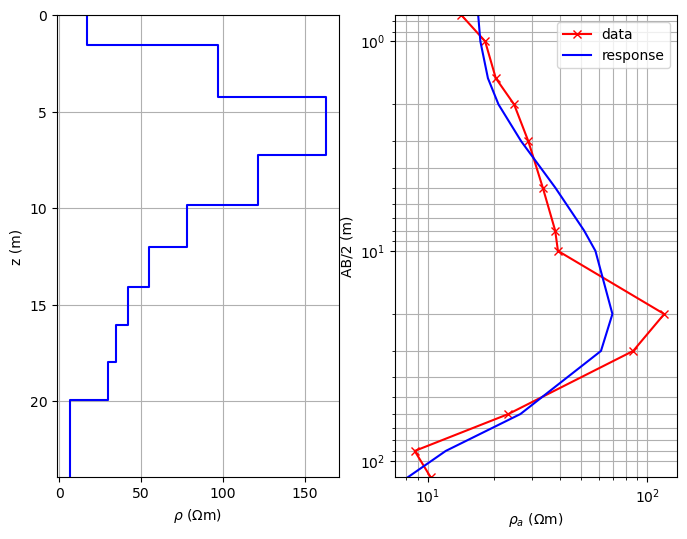

In [5]:
# create some transformations used for inversion
transThk = pg.trans.TransLog()  # log-transform ensures thk>0
transRho = pg.trans.TransLogLU(1, 1000)  # lower and upper bound
transRhoa = pg.trans.TransLog()  # log transformation for data
###############################################################################
# set model transformation for thickness and resistivity
f.region(0).setTransModel(transThk)  # 0=thickness
f.region(1).setTransModel(transRho)  # 1=resistivity
###############################################################################
# generate start model values from median app. resistivity & spread
paraDepth = max(ab2) / 3.  # rule-of-thumb for Wenner/Schlumberger
f.region(0).setStartValue(paraDepth / nlay / 2)
f.region(1).setStartValue(np.median(rhoa))
###############################################################################
#############################################################################
# set up inversion
inv = pg.core.Inversion(rhoa, f, transRhoa, False)  # data vector, fop, verbose
# could also be set by inv.setTransData(transRhoa)
###############################################################################
# set error model, regularization strength and Marquardt scheme
inv.setRelativeError(errPerc / 100.0)  # alternative: setAbsoluteError in Ohmm
lam = 200.  # (initial) regularization parameter
inv.setLambda(lam)  # (initial) regularization parameter
inv.setMarquardtScheme(0.9)  # decrease lambda by factor 0.9
model = f.createStartVector()  # creates from region start value
#model[nlay] = 1.5  # change default model by changing 2nd layer resistivity
inv.setModel(model)  #
###############################################################################
# run actual inversion and extract resistivity and thickness
model = inv.run()  # result is a pg.Vector, but compatible to numpy array
res, thk = model[nlay-1:nlay*2-1], model[0:nlay-1]
print('rrms={:.2f}%, chi^2={:.3f}'.format(inv.relrms(), inv.chi2()))
###############################################################################
# show estimated&synthetic models and data with model response in 2 subplots
fig, ax = plt.subplots(ncols=2, figsize=(8, 6))  # two-column figure
#drawModel1D(ax[0], synthk, synres, plot='semilogx', color='r')
drawModel1D(ax[0], thk, res, color='b')
ax[0].grid(True, which='both')
ax[0].set_ylabel('z (m)')
ax[0].set_xlabel(r'$\rho$ ($\Omega$m)')
ax[1].loglog(rhoa, ab2, 'rx-', label='data')  # sounding curve
ax[1].loglog(inv.response(), ab2, 'b-', label='response')
ax[1].set_ylim((max(ab2), min(ab2)))  # downwards according to penetration
ax[1].grid(True, which='both')
ax[1].set_xlabel(r'$\rho_a$ ($\Omega$m)')
ax[1].set_ylabel('AB/2 (m)')
ax[1].legend(loc='best')
plt.show()


In [6]:
# survey 2
nlay = 10  # number of layers
errPerc = 10.0  # relative error of 3 percent
########################
ab2 = [1.5,   2,    3,   5,   10,  20]
mn2 = [.5,   .5,  .5,  .5,   .5,   .5]
rho = [ 38,  22,  11,  4.5,  1,   .36]
ab2 = np.array(ab2)
mn2 = np.array(mn2)
rho = np.array(rho)
# initialize the forward modelling operator
f = pg.core.DC1dModelling(nlay, ab2, mn2)

In [7]:
rhoa=(np.pi/(8*mn2)) * ( ab2**2 - mn2**2 ) *rho
rhoa

array([ 59.69026042,  64.79534848,  75.59457323,  87.47372045,
        78.3434668 , 113.02664969])

./core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
./core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
./core/src/modellingbase.cpp:554		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


rrms=9.80%, chi^2=0.890


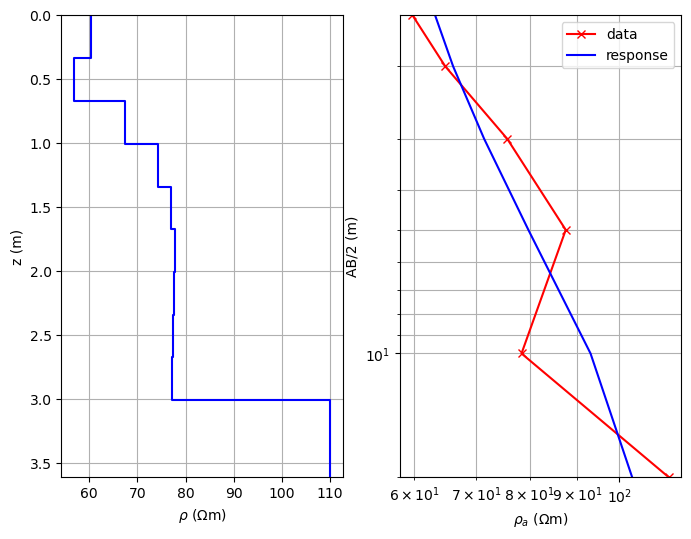

In [9]:
# create some transformations used for inversion
transThk = pg.trans.TransLog()  # log-transform ensures thk>0
transRho = pg.trans.TransLogLU(1, 1000)  # lower and upper bound
transRhoa = pg.trans.TransLog()  # log transformation for data
###############################################################################
# set model transformation for thickness and resistivity
f.region(0).setTransModel(transThk)  # 0=thickness
f.region(1).setTransModel(transRho)  # 1=resistivity
###############################################################################
# generate start model values from median app. resistivity & spread
paraDepth = max(ab2) / 3.  # rule-of-thumb for Wenner/Schlumberger
f.region(0).setStartValue(paraDepth / nlay / 2)
f.region(1).setStartValue(np.median(rhoa))
###############################################################################
#############################################################################
# set up inversion
inv = pg.core.Inversion(rhoa, f, transRhoa, False)  # data vector, fop, verbose
# could also be set by inv.setTransData(transRhoa)
###############################################################################
# set error model, regularization strength and Marquardt scheme
inv.setRelativeError(errPerc / 100.0)  # alternative: setAbsoluteError in Ohmm
lam = 200.  # (initial) regularization parameter
inv.setLambda(lam)  # (initial) regularization parameter
inv.setMarquardtScheme(0.9)  # decrease lambda by factor 0.9
model = f.createStartVector()  # creates from region start value
#model[nlay] = 1.5  # change default model by changing 2nd layer resistivity
inv.setModel(model)  #
###############################################################################
# run actual inversion and extract resistivity and thickness
model = inv.run()  # result is a pg.Vector, but compatible to numpy array
res, thk = model[nlay-1:nlay*2-1], model[0:nlay-1]
print('rrms={:.2f}%, chi^2={:.3f}'.format(inv.relrms(), inv.chi2()))
###############################################################################
# show estimated&synthetic models and data with model response in 2 subplots
fig, ax = plt.subplots(ncols=2, figsize=(8, 6))  # two-column figure
#drawModel1D(ax[0], synthk, synres, plot='semilogx', color='r')
drawModel1D(ax[0], thk, res, color='b')
ax[0].grid(True, which='both')
ax[0].set_ylabel('z (m)')
ax[0].set_xlabel(r'$\rho$ ($\Omega$m)')
ax[1].loglog(rhoa, ab2, 'rx-', label='data')  # sounding curve
ax[1].loglog(inv.response(), ab2, 'b-', label='response')
ax[1].set_ylim((max(ab2), min(ab2)))  # downwards according to penetration
ax[1].grid(True, which='both')
ax[1].set_xlabel(r'$\rho_a$ ($\Omega$m)')
ax[1].set_ylabel('AB/2 (m)')
ax[1].legend(loc='best')
plt.show()
